In [1]:
# Modeling Concept = balancing "bias" vs "variance"
# looking for low bias and low variance, but in reality a trade off
# linear fit vs quadratic vs spline (overfit?)
# complexity selection = underfit vs overfit = (low = underfit,high bias,low variance) (high = overfit, low bias, high variance))
print('')


In [2]:
# Logistic Regression Intro
# A classification problem is when you try to predict discrete outcomes, such as whether someone died or has a disease
# binary classification cannot use linear regression fit
# transfer to logistic function (sigmoid function) between 0 and 1
# from y = b + mx or y = b0 + b1x to 1+e^(-z) where z = b0 + b1x


# use a confusion matrix for evaluating the model
# true positive (predict = yes, reality = yes) and true negative vs 
# false positive (we predict yes, reality = no) (we tell a man he is pregnant) and false negative (we predict no, reality yes)
# type 1 error = false positive, type 2 = false negative
# accuracy = (TP + TN) / total
# misclassification (FP + FN) / total

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [3]:
train = pd.read_csv('titanic_train.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


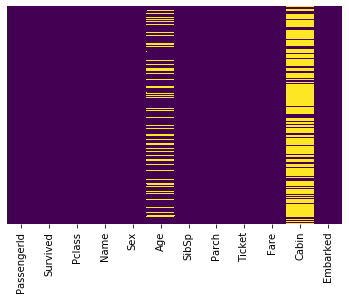

In [4]:
# exploratory data analysis
# we are missing a lot of data but how do we see it
train.isnull() # gets booleans of true and false
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

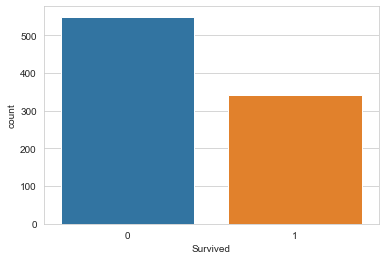

In [5]:
sns.set_style('whitegrid')

# who survived
sns.countplot(x='Survived',data=train)

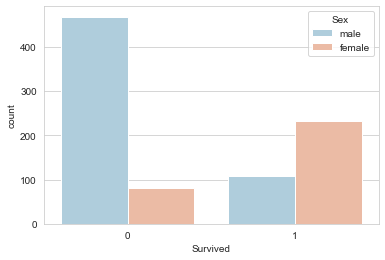

In [6]:
# who survived (male vs female)
sns.countplot(x='Survived', hue='Sex', data=train, palette='RdBu_r') # looks like males lower likelihood to survive

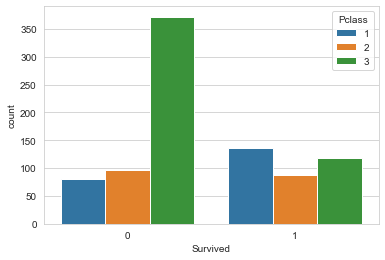

In [7]:
# who survived (passenger class)
sns.countplot(x='Survived', hue='Pclass', data=train) # looks like third class lower survival rate

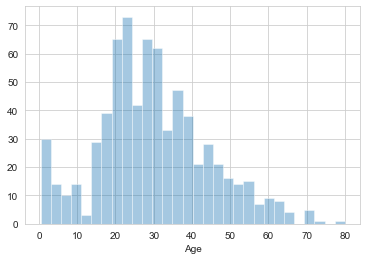

In [8]:
# age 
sns.distplot(train['Age'].dropna(), kde=False, bins=30)

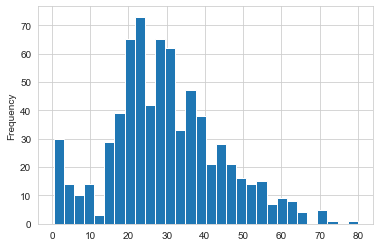

In [9]:
# another way to do histogram
train['Age'].plot.hist(bins=30)

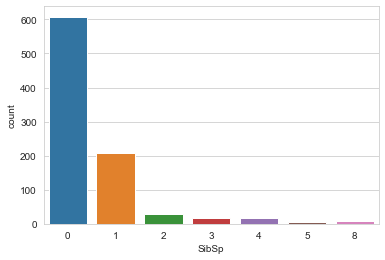

In [10]:
# sibling and spouse, most likely men in the third class, single
sns.countplot(x='SibSp', data=train)

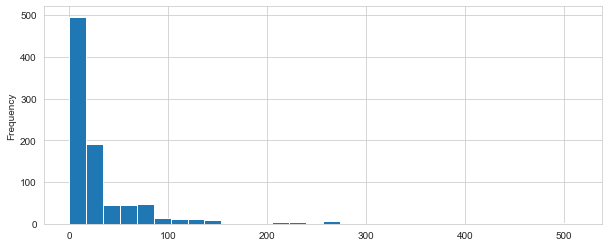

In [11]:
# another way to do histogram
train['Fare'].plot.hist(bins=30, figsize=(10,4))

In [12]:
# an interactive way to see it
import cufflinks as cf
cf.go_offline()
train['Fare'].iplot(kind='hist',bins=50)

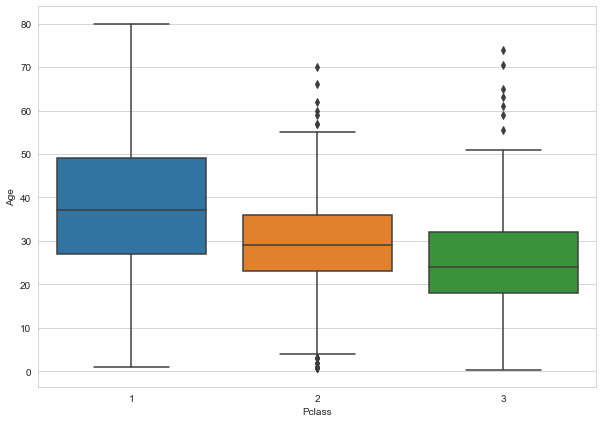

In [13]:
# so now we can fill in the NaN values with averages (maybe average age by passenger class)

plt.figure(figsize=(10,7))
sns.boxplot(x='Pclass', y='Age', data=train) # maybe older folks have more wealth over time

In [14]:
# one way of filling in the gaps for age - using an average based on passenger class
# the numbers are the eyeball of above bar charts
# in reality could use mean() function
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    if pd.isnull(Age):
        if Pclass == 1:
            return 37
        elif Pclass == 2:
            return 29
        elif Pclass == 3:
            return 24
    else:
        return Age # if you know the age


train['Age'] = train[['Age','Pclass']].apply(impute_age,axis=1)

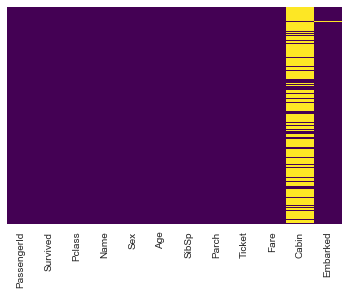

In [15]:
# check if we did it correctly by filling in the ages
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [16]:
# throw out any more missing values since not useful
train.drop('Cabin',axis=1,inplace=True)
train.dropna(inplace=True)

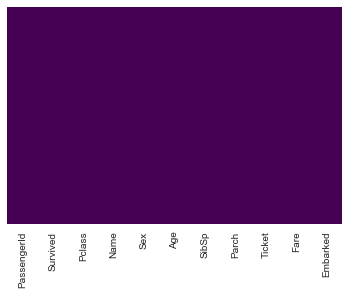

In [17]:
# check if we did it correctly 
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [18]:
# ML Dummy Variables - convert gender letter to 0 or 1
# cannot keep both female and male due to multicollinearity (ex. female = 0 will perfectly predict male =1, so drop one)
# female is first, drop first means female column is deleted but all you need is male = true/false
pd.get_dummies(train['Sex'], drop_first=True)
sex = pd.get_dummies(train['Sex'], drop_first=True)
sex

,male
0,1
1,0
2,0
3,0
4,1
...,...
886,1
887,0
888,0
889,1


In [19]:
# do same for where embarked
# here there are 3 possible locations for getting on, so drop the first one and check the last two
embark = pd.get_dummies(train['Embarked'], drop_first=True)
embark.head() # notice they are not perfect predictors

,Q,S
0,0,1
1,0,0
2,0,1
3,0,1
4,0,1


In [20]:
# add these new columns to the data set
train = pd.concat([train,sex,embark],axis=1)
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,male,Q,S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,0,0,0


In [21]:
# drop columns you will not use
train.drop(['Sex','Embarked','Name','Ticket'], axis=1, inplace=True) # axis = 1 is columns

In [22]:
# looks good, all numbers, but wait, one column not useful, which is passenger ID
train.tail()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
886,887,0,2,27.0,0,0,13.00,1,0,1
887,888,1,1,19.0,0,0,30.00,0,0,1
888,889,0,3,24.0,1,2,23.45,0,0,1
889,890,1,1,26.0,0,0,30.00,1,0,0
890,891,0,3,32.0,0,0,7.75,1,1,0


In [23]:
train.drop('PassengerId', axis=1,inplace=True)

In [24]:
# finally finished cleaning data - so we are ready to begin 
# perhaps Pclass could be enhanced because 1 2 3 is still a linear variable 
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


In [25]:
# now scikit learn
X = train.drop('Survived',axis=1)
y = train['Survived']

from sklearn.model_selection import train_test_split

# we split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101) # typically 40% = 0.4 or 0.3

In [26]:
X_train

,Pclass,Age,SibSp,Parch,Fare,male,Q,S
807,3,18.0,0,0,7.7750,0,0,1
651,2,18.0,0,1,23.0000,0,0,1
2,3,26.0,0,0,7.9250,0,0,1
690,1,31.0,1,0,57.0000,1,0,1
196,3,24.0,0,0,7.7500,1,1,0
...,...,...,...,...,...,...,...,...
576,2,34.0,0,0,13.0000,0,0,1
840,3,20.0,0,0,7.9250,1,0,1
338,3,45.0,0,0,8.0500,1,0,1
524,3,24.0,0,0,7.2292,1,0,0


In [27]:
from sklearn.linear_model import LogisticRegression
#logmodel = LogisticRegression(solver='liblinear') 
logmodel = LogisticRegression(solver='lbfgs',random_state=None, multi_class="auto", n_jobs=-1, C=1) 
# FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
# liblinear is the default solver for Scikit-learn versions < 0.22.0, cannot be parallelized over multiple processor cores
# lbfgs is the default solver for later versions
# Regularization shifts your model toward the bias side of things in the bias/variance tradeoff. 
# To be safe, scale your data
logmodel.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [28]:
predictions = logmodel.predict(X_test)

In [29]:
# precision table
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

# to improve results:
# 1) scale your data
# 2) Removing outliers will generally improve model performance. Standardizing the inputs would reduce outlier effects
# 3) Independent observations 
# 4) Higher order polynomial instead of linear. Risk of overfitting and finding global minimum
# 5) PCA and Feature Reduction
# 6) Multicollinearity (use Variance Inflation Factor (VIF). A VIF cutoff around 5 to 10 is common
# Compute the VIF by taking the correlation matrix, inverting it, and taking the values on the diagonal for each feature.)

              precision    recall  f1-score   support

           0       0.83      0.90      0.86       163
           1       0.82      0.71      0.76       104

    accuracy                           0.83       267
   macro avg       0.83      0.81      0.81       267
weighted avg       0.83      0.83      0.83       267



In [30]:
# confusion matrix 
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,predictions)) # many more enhancements available also - names, classes, location of cabin

#                    ACTUAL
# PREDICTED TRUE     TP FP
# PREDICTED FALSE    FN TN

[[147  16]
 [ 30  74]]


In [31]:
# check model output
print('Model outputs: \nIntercept = ', logmodel.intercept_, '\nCoefficients: ', logmodel.coef_)
print('\n *******************************************')

#pd.concat(logmodel.coef_, X_train.columns)
print('DataFrame: ')
print(pd.DataFrame(data=logmodel.coef_, columns=X_train.columns))
print('\n *******************************************')

# list/zip
print('List Zip: ')
print(list(zip(X_train.columns, logmodel.coef_[0,:])))
print('\n *******************************************')

# dict 1:
print('Dict two flavors: ')
coef_dict = {}
for coef, feat in zip(logmodel.coef_[0,:],X_train.columns):
    coef_dict[feat] = coef

print(coef_dict)
print('\n *******************************************')
# dict 2:
coef_dict2 = dict(zip(X_train.columns, logmodel.coef_[0,:]))
print(coef_dict2)

Model outputs: 
Intercept =  [5.22764978] 
Coefficients:  [[-1.20539117e+00 -4.56890634e-02 -2.55799021e-01 -2.17119203e-02
   1.34709939e-03 -2.45175624e+00  1.15862299e-01 -1.70722123e-01]]

 *******************************************
DataFrame: 
     Pclass       Age     SibSp     Parch      Fare      male         Q  \
0 -1.205391 -0.045689 -0.255799 -0.021712  0.001347 -2.451756  0.115862   

          S  
0 -0.170722  

 *******************************************
List Zip: 
[('Pclass', -1.2053911739863876), ('Age', -0.04568906344788851), ('SibSp', -0.25579902114717334), ('Parch', -0.021711920347426365), ('Fare', 0.0013470993863789334), ('male', -2.4517562350568354), ('Q', 0.11586229921572777), ('S', -0.17072212263717573)]

 *******************************************
Dict two flavors: 
{'Pclass': -1.2053911739863876, 'Age': -0.04568906344788851, 'SibSp': -0.25579902114717334, 'Parch': -0.021711920347426365, 'Fare': 0.0013470993863789334, 'male': -2.4517562350568354, 'Q': 0.11586

In [32]:
# 6) Multicollinearity (use Variance Inflation Factor (VIF). A VIF cutoff around 5 to 10 is common
# Compute the VIF by taking the correlation matrix, inverting it, and taking the values on the diagonal for each feature.)

from statsmodels.stats.outliers_influence import variance_inflation_factor
X_VIF = X.assign(const=1)
pd.Series([variance_inflation_factor(X_VIF.values, i) 
               for i in range(X_VIF.shape[1])], 
              index=X_VIF.columns)

Pclass     1.850747
Age        1.298698
SibSp      1.288332
Parch      1.331468
Fare       1.648179
male       1.126040
Q          1.489282
S          1.466941
const     35.438757
dtype: float64

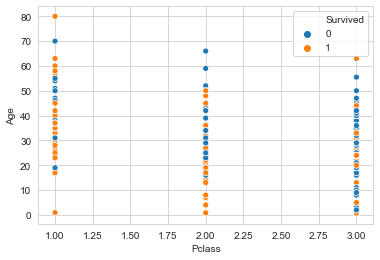

In [33]:
# scatter plot the results
sns.scatterplot(x=X_test['Pclass'],y=X_test['Age'],hue=y_test)

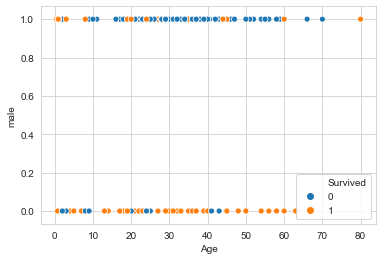

In [34]:
# scatter plot the results
sns.scatterplot(x=X_test['Age'],y=X_test['male'],hue=y_test)

Text(0.5, 1.0, 'Feature 3: SibSp = 0.5 +/- 1')

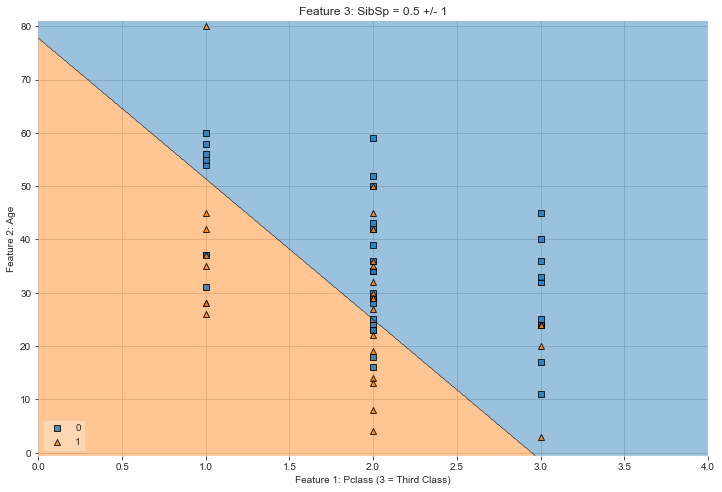

In [35]:
# Another way to visualize the output: using regions and colors (mlxtend library)
# needs another library: pip install mlxtend

from mlxtend.plotting import plot_decision_regions

# Plotting decision regions
# plot_decision_regions(x is a np array, y is a numpy array, cdf is a predict() method)
# this would work if only 2 features:
#plot_decision_regions(np.array(X_test[['male','Age']]), np.array(y_test), clf=logmodel, legend=2)


# trying for >=2 features
# Decision region for feature 3 = 0.5
value = 0.5
# Plot training sample with feature 3 = 0.5 +/- 1
width = 1
fig, ax = plt.subplots(figsize=(12,8))
plot_decision_regions(np.array(X_test), np.array(y_test), 
                  filler_feature_values={2: value, 3:0.4, 4:32, 5:0.6, 6:0.08, 7:0.7}, # i used mean
                  filler_feature_ranges={2: width, 3:width, 4:20, 5:width, 6:width, 7:width}, # i used std dev
                clf=logmodel, legend=3, 
                      X_highlight=None,
                      ax=ax)

# notes:
"""
# how to set value and width for the features 2 to 7:

X_train.mean()
0: Pclass     2.305466
1: Age       29.069534
2: SibSp      0.524116
3: Parch      0.377814
4: Fare      32.432388
5: male       0.639871
6: Q          0.085209
7: S          0.726688

X_train.std()
Pclass     0.841708
Age       12.889703
SibSp      1.083575
Parch      0.810771
Fare      51.212127
male       0.480424
Q          0.279417
S          0.446018

pd.DataFrame(data=np.array(list(zip(X_train.mean(), X_train.std()))).T, index=['Mean','Std'],columns=X_train.columns)
pd.DataFrame(data=list(zip(X_train.mean(), X_train.std())), columns=['Mean','Std'],index=X_train.columns)
pd.DataFrame(data=list(zip(X_train.columns, X_train.mean(), X_train.std())), columns=['Feature','Mean','Std'])

"""
ax.set_xlabel('Feature 1: Pclass (3 = Third Class)')
ax.set_ylabel('Feature 2: Age')
ax.set_title('Feature 3: SibSp = {} +/- {}'.format(value, width))

In [36]:
# Diagram only shows 2 features: 0 to 2 (excluding 2) so just 0 and 1
# Assumes other features are held constant
X_train.columns[0:2]

Index(['Pclass', 'Age'], dtype='object')

In [37]:
# Features assumed held constant
X_train.columns[2:]

Index(['SibSp', 'Parch', 'Fare', 'male', 'Q', 'S'], dtype='object')

In [38]:
np.array(y_test)

array([0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 0], dtype=int64)

In [39]:
pd.DataFrame(data=list(zip(X_train.columns, X_train.mean(), X_train.std())), columns=['Feature','Mean','Std'])

,Feature,Mean,Std
0,Pclass,2.305466,0.841708
1,Age,29.069534,12.889703
2,SibSp,0.524116,1.083575
3,Parch,0.377814,0.810771
4,Fare,32.432388,51.212127
5,male,0.639871,0.480424
6,Q,0.085209,0.279417
7,S,0.726688,0.446018


In [40]:
# VIF Test - Other ways to calculate it
import pandas as pd
import numpy as np

a = [1, 1, 2, 3, 4]
b = [2, 2, 3, 2, 1]
c = [4, 6, 7, 8, 9]
d = [4, 3, 4, 5, 4]

df = pd.DataFrame({'a':a,'b':b,'c':c,'d':d})
df_cor = df.corr()
vif_matrix = pd.DataFrame(np.linalg.inv(df.corr().values), index = df_cor.index, columns=df_cor.columns)
np.diag(vif_matrix)

array([22.95,  3.  , 12.95,  3.  ])

In [41]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = df.assign(const=1)
pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)

a         22.950
b          3.000
c         12.950
d          3.000
const    136.875
dtype: float64

In [42]:
# More VIF

"""
a <- c(1, 1, 2, 3, 4)
b <- c(2, 2, 3, 2, 1)
c <- c(4, 6, 7, 8, 9)
d <- c(4, 3, 4, 5, 4)

df <- data.frame(a, b, c, d)
vif_df <- vif(df)
print(vif_df)

Variables   VIF
   a        22.95
   b        3.00
   c        12.95
   d        3.00
"""

import pandas as pd
import statsmodels.formula.api as smf

def get_vif(exogs, data):
    '''Return VIF (variance inflation factor) DataFrame

    Args:
    exogs (list): list of exogenous/independent variables
    data (DataFrame): the df storing all variables

    Returns:
    VIF and Tolerance DataFrame for each exogenous variable

    Notes:
    Assume we have a list of exogenous variable [X1, X2, X3, X4].
    To calculate the VIF and Tolerance for each variable, we regress
    each of them against other exogenous variables. For instance, the
    regression model for X3 is defined as:
                        X3 ~ X1 + X2 + X4
    And then we extract the R-squared from the model to calculate:
                    VIF = 1 / (1 - R-squared)
                    Tolerance = 1 - R-squared
    The cutoff to detect multicollinearity:
                    VIF > 10 or Tolerance < 0.1
    '''

    # initialize dictionaries
    vif_dict, tolerance_dict = {}, {}

    # create formula for each exogenous variable
    for exog in exogs:
        not_exog = [i for i in exogs if i != exog]
        formula = f"{exog} ~ {' + '.join(not_exog)}"

        # extract r-squared from the fit
        r_squared = smf.ols(formula, data=data).fit().rsquared

        # calculate VIF
        vif = 1/(1 - r_squared)
        vif_dict[exog] = vif

        # calculate tolerance
        tolerance = 1 - r_squared
        tolerance_dict[exog] = tolerance

    # return VIF DataFrame
    df_vif = pd.DataFrame({'VIF': vif_dict, 'Tolerance': tolerance_dict})

    return df_vif

In [43]:
# take a diff boston data set
from sklearn.datasets import load_boston
boston = load_boston()

# dictionary
boston.keys()
print(boston.keys())
print('\n *******************************************')
print(boston['feature_names'])
print('\n *******************************************')
print(boston['DESCR'])
print('\n *******************************************')
print(boston['data'])
print('\n *******************************************')


dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

 *******************************************
['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']

 *******************************************
.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-oc